In [16]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep  6 18:33:18 2018

@author: bjogut and simoca
"""
from scipy.integrate import odeint
# Package for plotting
import math
# Package for the use of vectors and matrix
import numpy as np
import pandas as pd
import array as arr
#from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import glob
from random import sample
import random
import time
import plotly
import plotly.graph_objs as go
import json
from plotly.subplots import make_subplots
import itertools


In [17]:
def update_param_value(param, new_value):

    class_name = str(self.__class__).split('.')[1].split("'")[0]
    param_current_value = self.__dict__.get(param, None)

    if param_current_value is None:
        print("Class {} does not contain param with name {}".format(class_name, param))
        return

    self.__dict__[param] = new_value
    print("Value of param {} in class {} updated to {}".format(param, class_name, new_value))

def rxn(C, t, u, fc):
    # when there is no control, k has no effect
    k = 1
    # when cooling is off than u = 0
    if coolingOn == False:
        u = 0
    if Contamination == True:
        fc = np.random.randint(0, 10)
        fc = fc / 17

    if Control == True:
        # Cardinal temperature model with inflection: Salvado et al 2011 "Temperature Adaptation Markedly Determines Evolution within the Genus Saccharomyces"
        # Strain S. cerevisiae PE35 M
        Topt = 30
        Tmax = 45.48
        Tmin = 5.04
        T = C[5]
        if T < Tmin or T > Tmax:
            k = 0
        else:
            D = (T - Tmax) * (T - Tmin) ** 2
            E = (Topt - Tmin) * ((Topt - Tmin) * (T - Topt) - (Topt - Tmax) * (Topt + Tmin - 2 * T))
            k = D / E
    # matrix
    # number of components
    n = 4
    m = 4
    # initialize the stoichiometric matrix, s
    s = np.zeros((m, n))
    s[0, 0] = -1
    s[0, 1] = 0
    s[0, 2] = -Y_OG
    s[0, 3] = Yox_XG

    s[1, 0] = -1
    s[1, 1] = Y_EG
    s[1, 2] = 0
    s[1, 3] = Yred_XG

    s[2, 0] = 0
    s[2, 1] = -1
    s[2, 2] = -Y_OE
    s[2, 3] = Yox_XE

    s[3, 0] = 0
    s[3, 1] = 0
    s[3, 2] = 1
    s[3, 3] = 0
    # initialize the rate vector
    rho = np.zeros((4, 1))
    ##initialize the overall conversion vector
    r = np.zeros((4, 1))
    # Volume balance
    if (t >= t_expfb_start):
        if (t < t_constfb_start):
            Fin = F0 * math.exp(SFR * (t - t_expfb_start))
            Fout = 0
        else:
            Fin = F0 * math.exp(SFR * (t_constfb_start - t_expfb_start))
            Fout = 0
    else:
        Fin = 0
        Fout = 0

    F = Fin - Fout

    rho[0, 0] = ((1 / Y_OG) * min(q_o * (C[2] / (C[2] + Ko)),
                                       Y_OG * (q_g * (C[0] / (C[0] + Kg))))) * C[3]
    rho[1, 0] = ((1 - math.exp(-t / t_lag)) * (
                (q_g * (C[0] / (C[0] + Kg))) - (1 / Y_OG) * min(
            q_o * (C[2] / (C[2] + Ko)), Y_OG * (q_g * (C[0] / (C[0] + Kg)))))) * C[3]
    rho[2, 0] = ((1 / Y_OE) * min(
        q_o * (C[2] / (C[2] + Ko)) - (1 / Y_OG) * min(q_o * (C[2] / (C[2] + Ko)),
            Y_OG * (q_g * (C[0] / (C[0] + Kg)))),
        Y_OE * (q_e * (C[1] / (C[1] + Ke)) * (Ki / (C[0] + Ki))))) * C[3]
    rho[3, 0] = kla * (O_sat - C[2])

    # Developing the matrix, the overall conversion rate is stoichiometric *rates
    r[0, 0] = (s[0, 0] * rho[0, 0]) + (s[1, 0] * rho[1, 0]) + (s[2, 0] * rho[2, 0]) + (s[3, 0] * rho[3, 0])
    r[1, 0] = (s[0, 1] * rho[0, 0]) + (s[1, 1] * rho[1, 0]) + (s[2, 1] * rho[2, 0]) + (s[3, 1] * rho[3, 0])
    r[2, 0] = (s[0, 2] * rho[0, 0]) + (s[1, 2] * rho[1, 0]) + (s[2, 2] * rho[2, 0]) + (s[3, 2] * rho[3, 0])
    r[3, 0] = (s[0, 3] * rho[0, 0]) + (s[1, 3] * rho[1, 0]) + (s[2, 3] * rho[2, 0]) + (s[3, 3] * rho[3, 0])

    # Solving the mass balances terms for dilution, addtion and washing out added
    dGdt = r[0, 0] - F / C[4] * C[0] + Fin / C[4] * Cin - Fout / C[4] * C[0]
    dEdt = r[1, 0] - F / C[4] * C[1] - Fout / C[4] * C[1]
    dOdt = r[2, 0]
    dXdt = r[3, 0] - F / C[4] * C[3] - Fout / C[4] * C[3]
    dVdt = F

    if Control == True:
        '''
         dHrxn heat produced by cells estimated by yeast heat combustion coeficcient dhc0 = -21.2 kJ/g
         dHrxn = dGdt*V*dhc0(G)-dEdt*V*dhc0(E)-dXdt*V*dhc0(X)
         (when cooling is working)  Q = - dHrxn -W ,
         dT = V[L] * 1000 g/L / 4.1868 [J/gK]*dE [kJ]*1000 J/KJ
         dhc0(EtOH) = -1366.8 kJ/gmol/46 g/gmol [KJ/g]
         dhc0(Glc) = -2805 kJ/gmol/180g/gmol [KJ/g]

        '''
        # Metabolic heat: [W]=[J/s], dhc0 from book "Bioprocess Engineering Principles" (Pauline M. Doran) : Appendix Table C.8
        dHrxndt = dXdt * C[4] * (-21200)  # [J/s]  + dGdt*C[4]*(15580)- dEdt*C[4]*(29710)
        # Shaft work 1 W/L1
        W = 1 * C[4]  # [J/S] negative because exothermic
        # Cooling just an initial value (constant cooling to see what happens)
        # dQdt = -0.03*C[4]*(-21200) #[J/S]
        # velocity of cooling water: u [m3/h] -->controlled by PID

        # Mass flow cooling water
        M = u / 3600 * 1000  # [kg/s]
        # Define Tin = 5 C, Tout=TReactor
        # heat capacity water = 4190 J/kgK
        Tin = 5
        # Estimate water at outlet same as Temp in reactor
        Tout = C[5]
        cpc = 4190
        # Calculate Q from Eq 9.47
        Q = -M * cpc * (Tout - Tin)  # J/s
        # Calculate Temperature change
        dTdt = -1 * (dHrxndt - Q + W) / (C[4] * 1000 * 4.1868)  # [K/s]
    else:
        dTdt = 0
    return [dGdt, dEdt, dOdt, dXdt, dVdt, dTdt]

def solve(G0, O0, T0):
    # solve normal:
    t = np.linspace(t_start, t_end, steps)
    if Control == False:
        u = 0
        fc = 1
        C0 = [G0, E0, O0, X0, V0, T0]
        C = odeint(rxn, C0, t, rtol=1e-7, mxstep=500000, args=(u, fc,))

    # solve for Control
    else:
        fc = 0
        """
        PID Temperature Control:
        """
        # storage for recording values
        C = np.ones([len(t), 6])
        C0 = [G0, E0, O0, X0, V0, T0]
        C[0] = C0
        ctrl_output = np.zeros(len(t))  # controller output
        e = np.zeros(len(t))  # error
        ie = np.zeros(len(t))  # integral of the error
        dpv = np.zeros(len(t))  # derivative of the pv
        P = np.zeros(len(t))  # proportional
        I = np.zeros(len(t))  # integral
        D = np.zeros(len(t))  # derivative

        for i in range(len(t) - 1):
            # print(t[i])
            # PID control of cooling water
            dt = t[i + 1] - t[i]
            # Error
            e[i] = C[i, 5] - Tset
            # print(e[i])
            if i >= 1:
                dpv[i] = (C[i, 5] - C[i - 1, 5]) / dt
                ie[i] = ie[i - 1] + e[i] * dt
            P[i] = K_p * e[i]
            I[i] = K_i * ie[i]
            D[i] = K_d * dpv[i]

            ctrl_output[i] = P[i] + I[i] + D[i]
            u = ctrl_output[i]
            if u > u_max:
                u = u_max
                ie[i] = ie[i] - e[i] * dt  # anti-reset windup
            if u < u_min:
                u = u_min
                ie[i] = ie[i] - e[i] * dt  # anti-reset windup
            # time for solving ODE
            ts = [t[i], t[i + 1]]
            # disturbance
            # if self.t[i] > 5 and self.t[i] < 10:
            #   u = 0
            # solve ODE from last timepoint to new timepoint with old values

            y = odeint(rxn, C0, ts, rtol=1e-7, mxstep=500000, args=(u, fc,))
            # update C0
            C0 = y[-1]
            # merge y to C
            C[i + 1] = y[-1]
    return t, C

# def create_plot(self,t, C):
#     figure = make_subplots(rows = 2, cols= 1)
#
#     G = C[:, 0]
#     T = C[:, 5]

def create_plot(t, C):
    figure = make_subplots(rows=2, cols=1)
    G = C[:, 0]
    E = C[:, 1]
    B = C[:, 3]
    O = C[:, 2]
    df = pd.DataFrame({'t': t, 'G': G, 'B': B, 'E': E, 'O': O})
    figure.append_trace(go.Scatter(x=df['t'], y=df['G'], name='Glucose'), row=1, col=1)
    figure.append_trace(go.Scatter(x=df['t'], y=df['O'], name='Oxygen'), row=1, col=1)
    figure.append_trace(go.Scatter(x=df['t'], y=df['B'], name='Biomass'), row=1, col=1)
    figure.append_trace(go.Scatter(x=df['t'], y=df['E'], name='Ethanol'), row=1, col=1)
    # fig.update_layout(title=('Simulation of the model for the Scerevisiae'),
    #                   xaxis_title='time (h)',
    #                   yaxis_title='Concentration (g/L)')

    V = C[:, 4]
    df2 = pd.DataFrame({'t': t, 'V':V})
    figure.append_trace(go.Scatter(x=df2['t'], y=df2['V'], name='Volume'), row=2, col=1)
    figure.update_layout(title=('Simulation of the model for the Saccharomyces cerevisiae'),
                         xaxis_title='time (h)',
                         yaxis_title='Concentration (g/L)')

    # figure.append_trace(fig, row=1, col=1)
    # figure.append_trace(fig2, row=2, col=1)
    #print('print')
    #print('Check in the model done')
    graphJson = json.dumps(figure, cls=plotly.utils.PlotlyJSONEncoder)
    return graphJson

In [54]:
# C returns 6 arrays to solve the following differential equations: 
# dGdt, dEdt, dOdt, dXdt, dVdt, dTdt
# of which T and V are constant

def plot_final_concentrations(t, C):
    plt.figure(figsize=(10,5))
    plt.scatter(t, C[:, 0], c='red', label='glucose')
    plt.scatter(t, C[:, 1], c='blue', label='ethanol')
    plt.scatter(t, C[:, 2], c='green', label='oxygen')
    plt.scatter(t, C[:, 3], c='orange', label='biomass')
    
    plt.plot(t, C[:, 0], c='red', alpha=0.4)
    plt.plot(t, C[:, 1], c='blue', alpha=0.4)
    plt.plot(t, C[:, 2], c='green', alpha=0.4)
    plt.plot(t, C[:, 3], c='orange', alpha=0.4)
    plt.legend()
    plt.grid()
    plt.show() 

In [49]:
# yield
Yox_XG = 0.8
Yred_XG = 0.05
Yox_XE =  0.72
Y_OG = 1.067
Y_EG = 0.5
Y_OE = 1.5

q_g = 4.68
q_o = 0.37
q_e = 0.86
t_lag = 4.66

# rates
Kg = 0.17
Ke = 0.0001
Ko = 0.56
Ki = 0.31
O_sat = 0.00755
kla = 1004

# initial concentrations
G0 = 18
E0 = 0.34
O0 = 0.00755
X0 = 0.1
V0 = 2

# fedbatch parameters
Cin = 100
F0 = 0.05 
SFR = 0.15
t_expfb_start = 15
t_constfb_start = 18

# time
t_end = 30
t_start=0

# parameters for control, default every 1/24 hours:
Control = False
coolingOn = True
Contamination = False
#steps = (t_end - t_start) * 24
steps = t_end
T0 = 30
K_p = 2.31e+01
K_i = 3.03e-01
K_d = -3.58e-03
Tset = 30
u_max = 150
u_min = 0

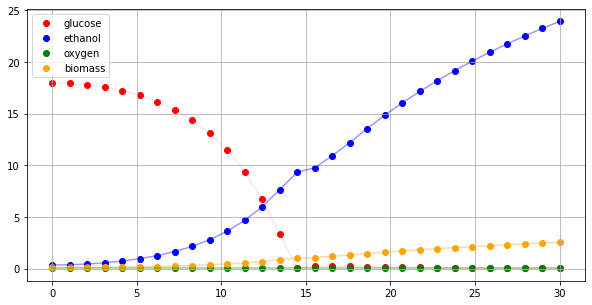

In [50]:
t1, C1 = solve(G0, O0, T0)
plot_final_concentrations(t1, C1)

In [5]:
_ = create_plot(t1, C1)

In [51]:
# Create a DoE with varying values of glucose, oxygen and temperature
# 3 factors and variable levels

T0 = [20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40] # C
G0 = [14, 15, 16, 17, 18, 19, 20, 21, 22] # g/L
O0 = [0.003775, 0.00755] # g/L
# kla
# u

doe = list(itertools.product(G0, O0, T0))

df = pd.DataFrame(doe)
df.head()
print(len(df))

198


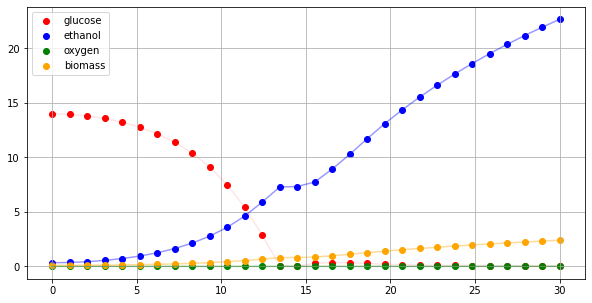

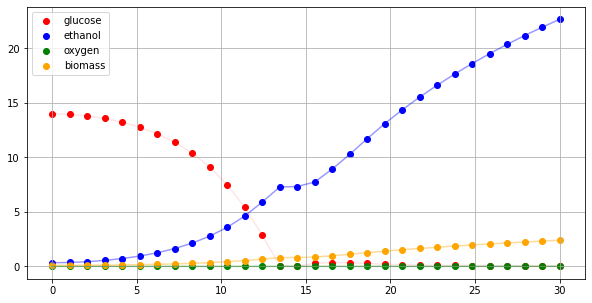

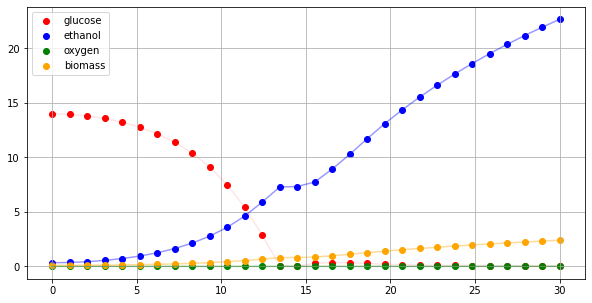

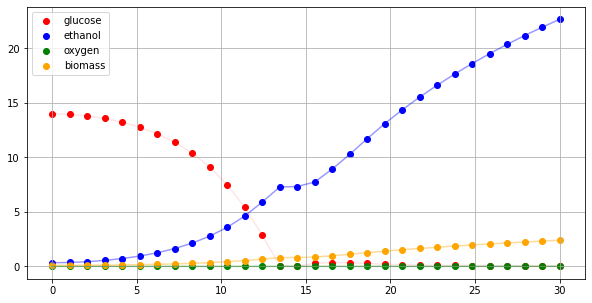

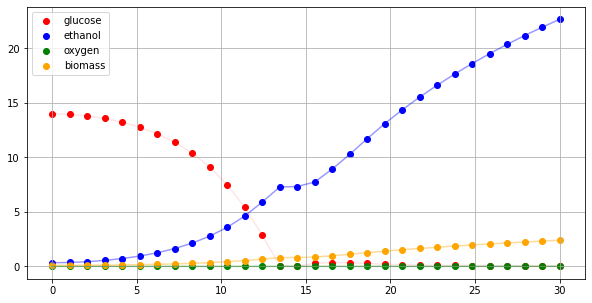

In [53]:
for glucose, oxygen, temp in zip(np.array(doe).T[0][:5], 
                                 np.array(doe).T[1][:5], 
                                 np.array(doe).T[2][:5]):
    t1, C1 = solve(glucose, oxygen, temp)
    plot_final_concentrations(t1, C1)